In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer, accuracy_score
import seaborn as sns
import itertools

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [26]:
X = add_feats(train, numerical_features)
y = train['Calories']

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,Age_x_Duration,Age_x_Heart_Rate,Age_x_Body_Temp,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,6804,2952,936,3636,1476.0,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,10432,3840,512,5440,2540.8,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,8211,3264,357,4284,2029.8,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,3840,1800,500,2100,814.0,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,6308,2318,950,3876,1542.8,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [27]:
train_FE = pd.concat([X, y], axis=1)

train_FE.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,Age_x_Duration,Age_x_Heart_Rate,Age_x_Body_Temp,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Calories
0,male,36,189,82,26,101,41.0,22.955684,6804,2952,936,3636,1476.0,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0,150
1,female,64,163,60,8,85,39.7,22.582709,10432,3840,512,5440,2540.8,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5,34
2,female,51,161,64,7,84,39.8,24.690405,8211,3264,357,4284,2029.8,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2,29
3,male,20,192,90,25,105,40.7,24.414062,3840,1800,500,2100,814.0,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5,140
4,female,38,166,61,25,102,40.6,22.136740,6308,2318,950,3876,1542.8,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2,146


C:\Users\eblac\AppData\Local\Temp\ipykernel_5956\2785241079.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


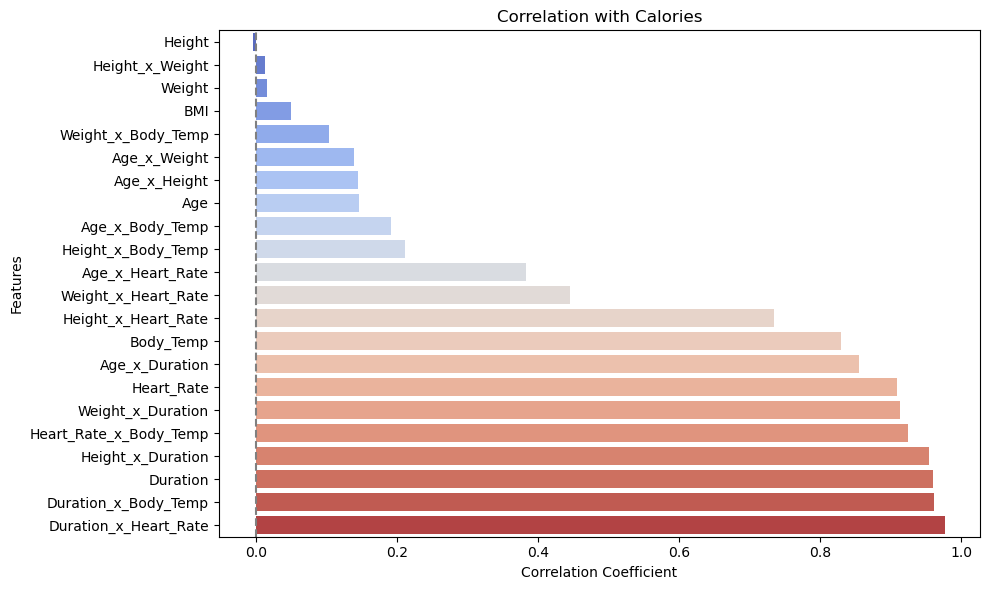

In [28]:
# Compute correlations
correlations = train_FE.corr(numeric_only=True)['Calories'].drop('Calories').sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation with Calories')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [29]:
feats = ['Duration_x_Heart_Rate',
         'Duration_x_Body_Temp',
         'Duration', 'Height_x_Duration',
         'Heart_Rate_x_Body_Temp',
         'Weight_x_Duration',
         'Heart_Rate',
         'Age_x_Duration',
         'Body_Temp'
         ]

X[feats].head()

,Duration_x_Heart_Rate,Duration_x_Body_Temp,Duration,Height_x_Duration,Heart_Rate_x_Body_Temp,Weight_x_Duration,Heart_Rate,Age_x_Duration,Body_Temp
0,2626,1066.0,26,4914,4141.0,2132,101,936,41.0
1,680,317.6,8,1304,3374.5,480,85,512,39.7
2,588,278.6,7,1127,3343.2,448,84,357,39.8
3,2625,1017.5,25,4800,4273.5,2250,105,500,40.7
4,2550,1015.0,25,4150,4141.2,1525,102,950,40.6


Train prediction: 0.1043179474938069
Test prediction: 0.10533625827161165


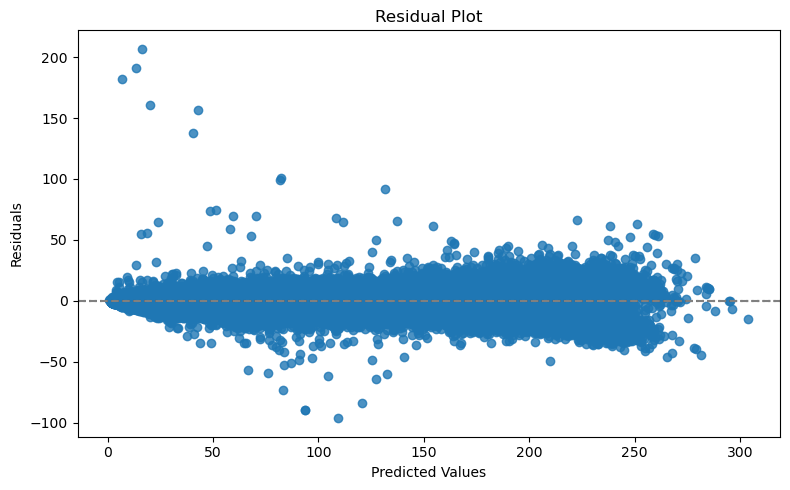

In [30]:
# Linear regression model using top 9 features with correlation to Calories
# kaggle score 0.10376 private, 0.10287 public

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[feats], y, test_size=0.2, random_state=431)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Train prediction: 0.09424016658525354
Test prediction: 0.0960362024079777


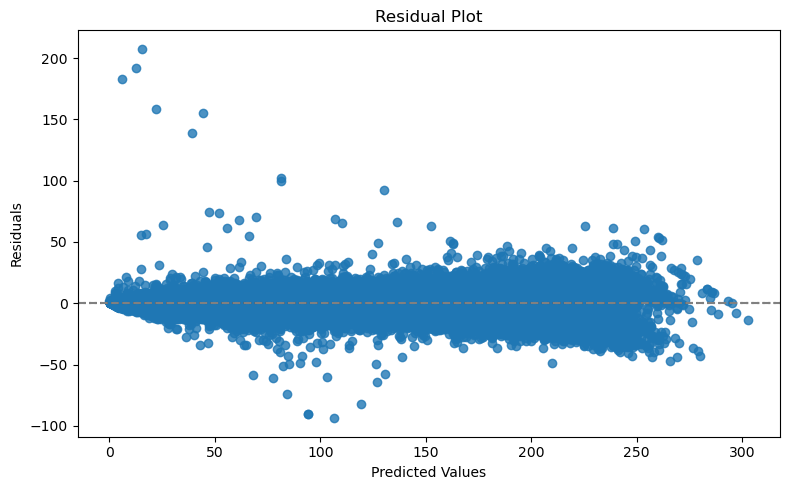

In [31]:
# Linear regression model using top 9 features and one-hot encoded Sex feature with correlation to Calories
# kaggle score 0.09345 private, 0.9344 public

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X[['Sex'] + feats], drop_first=True), y, test_size=0.2, random_state=431)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmsle(train_pred, y_train))
print("Test prediction:", rmsle(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=predictions, y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [16]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,Age_x_Duration,Age_x_Heart_Rate,Age_x_Body_Temp,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,315,3915,1791.0,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,520,2626,1053.0,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,464,2958,1171.6,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,780,4173,1583.4,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,480,2820,1215.0,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [18]:
# make the submission file!

pred = model.predict(pd.get_dummies(test_mod[['Sex'] + feats], drop_first=True))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = pred
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_4.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   28.529066
1  750001  109.870145
2  750002   91.870668
3  750003  131.855194
4  750004   72.592340

count    250000.000000
mean         88.251461
std          62.089027
min           0.055749
25%          34.127832
50%          76.767503
75%         135.918407
max         303.805384
Name: Calories, dtype: float64
